In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import texttable
import sys
sys.path.append("../src")
from data_proc import *
from policy import *
from simulate import *
from util import Progbar

pd.options.mode.chained_assignment = None

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

In [3]:
DATA_PATH = "../data/warfarin.csv"  # path to raw Warfarin data file

In [15]:
def evaluate_risk(simulator, policies, num_runs=100):
    """
    Simulates a list of policies, each for 'num_runs' times (using the same sets of random permutations);
    and compares the policies' regret & "risk":
    
    We judge a policy's risk based on how often it chooses low (high) when the optimal decision is high (low)
    
    simulator:
        WarfarinSimulator instance
    policies:
        List of (Policy, string) tuples, where the string is a description of the policy
        The Policy instances should implement reset(), choose_arm(), and update_policy()
    """
    train_size = simulator.train_size  # number of online learning steps
    
    # record simulation results
    header = ['Policy', 'Mean', 'Std', 'Max', 'Min']
    table_regret = texttable.Texttable()
    table_regret.header(header)
    table_risk = texttable.Texttable()
    table_risk.header(header)
    
    regret_list = []
    risk_list = []
    
    base_seed = np.random.randint(1000)  # randomizing dataset permutations
    for policy, policy_name in policies:
        print("Start simulating {}".format(policy_name))
    
        regrets = []  # total regrets
        risk_percent = []  # percentage of severe mistakes (low->high or high->low)
        progbar = Progbar(num_runs)  # progress bar
        for i in range(num_runs):
            policy.reset()  # Reset the policy to its initial states            
            simulator.simulate(policy, eval_every=10000, random_seed=(base_seed+i))
            regrets.append(simulator.get_total_regret())
            confusion_matrix = simulator.get_confusion_matrix()
            risk_percent.append((confusion_matrix[0,2] + confusion_matrix[2,0]) / train_size * 100)
            progbar.update(i+1)

        table_regret.add_row((policy_name, np.mean(regrets), np.std(regrets),
                              np.max(regrets), np.min(regrets)))
        table_risk.add_row((policy_name, np.mean(risk_percent), np.std(risk_percent),
                            np.max(risk_percent), np.min(risk_percent)))
        
        regret_list.append(np.mean(regrets))
        risk_list.append(np.mean(risk_percent))
    
    print("Regret Statistics:")
    print(table_regret.draw())
    print("Risk Statistics (Percentage of high->low & low->high decisions):")
    print(table_risk.draw())
    
    return regret_list, risk_list

# simulator = WarfarinSimulator(DATA_PATH, discretize_label_3, test_size=500, add_bias=True)
# num_features = simulator.num_features
# num_arms = simulator.num_arms

# evaluate_risk(simulator, [
#     (WarfarinLinearOraclePolicy(DATA_PATH, discretize_label_3), "LinearOracle"),
#     (LinUCBPolicy(num_features, num_arms, alpha=1.0), "LinUCB"),
#     (LinUCBSafePolicy(num_features, num_arms, alpha=1.0), "LinUCBSafe"),
#     (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0), "Greedy"),
#     (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda t: 0.2-t/20000), "EpsDecay"),
#     (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0.2), "EpsGreedy(0.2)"),
#     (WarfarinFixedDosePolicy(1), "Fixed-dose"),
# ], num_runs=500)

In [46]:
simulator = WarfarinSimulator(DATA_PATH, discretize_label_3, test_size=500, add_bias=True)
num_features = simulator.num_features
num_arms = simulator.num_arms
alpha = np.logspace(-1, 1, 5, endpoint=True)
regret_matrix, risk_matrix = [], []

for a in alpha:
    regret_list, risk_list = evaluate_risk(simulator, [
        (WarfarinLinearOraclePolicy(DATA_PATH, discretize_label_3), "LinearOracle"),
        (LinUCBPolicy(num_features, num_arms, alpha=a), "LinUCB"),
#         (LinUCBSafePolicy(num_features, num_arms, alpha=1.0), "LinUCBSafe"),
#         (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0), "Greedy"),
#         (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda t: 0.2-t/20000), "EpsDecay"),
#         (EpsilonGreedyPolicy(num_features, num_arms, eps_schedule=lambda x: 0.2), "EpsGreedy(0.2)"),
#         (WarfarinFixedDosePolicy(1), "Fixed-dose"),
    ], num_runs=500)
    regret_matrix.append(regret_list)
    risk_matrix.append(risk_list)

Instantiated a Warfarin Bandit simulator!
Reward structure: binary
Number of arms: 3
Number of features: 24
Size of training set for online learning: 5028
Size of holdout validation set: 500
Start simulating LinearOracle
500/500 [==============================] - 19s    
Start simulating LinUCB
500/500 [==============================] - 142s   
Regret Statistics:
+--------------+----------+--------+------+------+
|    Policy    |   Mean   |  Std   | Max  | Min  |
+==============+==========+========+======+======+
| LinearOracle | 1653.506 | 10.228 | 1686 | 1622 |
+--------------+----------+--------+------+------+
| LinUCB       | 1735.072 | 29.088 | 1878 | 1655 |
+--------------+----------+--------+------+------+
Risk Statistics (Percentage of high->low & low->high decisions):
+--------------+-------+-------+-------+-------+
|    Policy    | Mean  |  Std  |  Max  |  Min  |
+==============+=======+=======+=======+=======+
| LinearOracle | 0.181 | 0.017 | 0.199 | 0.119 |
+--------------+

In [47]:
print (regret_matrix)
print (risk_matrix)

[[1653.506, 1735.072], [1653.564, 1729.348], [1653.78, 1729.898], [1653.432, 1838.338], [1653.702, 2205.45]]
[[0.18138424821002386, 0.6342879872712808], [0.18007159904534603, 0.7221161495624503], [0.18134447096260936, 0.9616149562450279], [0.17975338106603025, 1.7595465393794747], [0.18019093078758952, 3.9571201272871916]]


In [64]:
def plot_helper(regret_matrix, risk_matrix, alpha):
    plt.figure()
    print (regret_matrix.shape)
#     print (alpha.shape)
#     print ()
    for i in range(len(regret_matrix[0])):
        print(i)
        plt.plot(alpha,regret_matrix[:,i])
    
    plt.legend(["LinearOracle","LinUCB"])
    plt.title("Regret vs Alpha")    
    plt.show()

(5, 2)
0
1


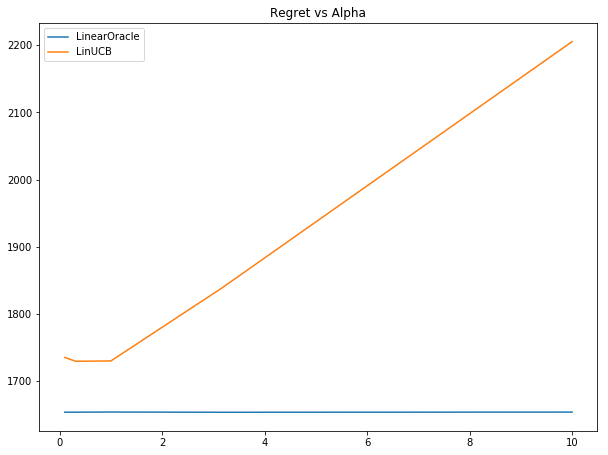

In [65]:
# alpha -> 400~500
# linUCB, oracle, greedy
# thompson sampling
# plot risk vs alpha, regret vs alpha
# alpha [0.1,10]
# algo linusbsafe
# reward

regret_matrix = np.array(regret_matrix)
# print (regret_matrix)
# print (regret_matrix.T)
# print (regret_matrix[0])

plot_helper(regret_matrix, risk_matrix, alpha)
